In [1]:
import os # file/directory operations
import numpy as np #Numerical computations and array
import matplotlib.pyplot as plt #Visualization
import cv2  #Image loading, resizing , filtering , etc
import tensorflow as tf
from tensorflow.keras.models import Sequential # for building CNN Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten , Dense , Dropout,BatchNormalization) # Model layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Augmentation
from tensorflow.keras.utils import to_categorical # For one-hot endcoding
#Data Splitting and Evaluation
from sklearn.model_selection import train_test_split # To split into train/val
from sklearn.metrics import classification_report # for performance evaluation
from tensorflow.keras.preprocessing import image

2025-05-18 07:09:17.996483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747552158.236974      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747552158.305282      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array

In [3]:
# def load_dataset(dataset_path, target_size=(128,128), test_size = 0.2):
#     """
#     Load images from dataset directory, preproocess , and split into train and val sets.
#     Args:
#          dataset_path (str): Path to PlantVillage dataset folder (with subfolders per class)
#          target_size (tuple): Image size to resize to.
#          test_size (float): Fraction of dataset for validation.

#     Returns:
#             X_train, X_val, y_train, y_val (np.arrays): Preprocessed and split data.
#             class_names (list) : List of class labels.
#     """
#     images = []
#     labels = []
#     class_names = sorted(os.listdir(dataset_path)) # Folder names = class names

#     for idx, class_name in enumerate(class_names):
#         class_folder = os.path.join(dataset_path,class_name)
#         if not os.path.isdir(class_folder):
#             continue
#         for img_file in os.listdir(class_folder):
#             img_path = os.path.join(class_folder, img_file)
#             try:
#                 img = preprocess_image(img_path, target_size) # call our preprocessing fn
#                 images.append(img)
#                 labels.append(idx)
#             except Exception as e:
#                 print(f"Error loading {img_path}:{e}")
#     images = np.array(images)
#     labels = np.array(labels)
#     #One-hot encode labels 
#     labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))
#     #split dataset
#     X_train, X_val , y_train , y_val = train_test_split(images, labels , test_size = test_size, random_state = 42, stratify = labels)
#     return X_train , X_val , y_train , y_val , class_names

In [4]:
def load_dataset(dataset_path, target_size=(64, 64), batch_size=32):
    """
    Efficiently load PlantVillage dataset using ImageDataGenerator
    Returns training & validation generators + class names.
    """

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    X_train = datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    X_val = datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Dummy vars to match your expected return signature
    y_train = X_train.classes
    y_val = X_val.classes
    class_names = list(X_train.class_indices.keys())

    return X_train, X_val, y_train, y_val, class_names

In [5]:
dataset_path = "/kaggle/input/plantvillage-dataset/color"
X_train, X_val , y_train , y_val , class_names = load_dataset(dataset_path)
print(f"\nLoaded {len(X_train)} training images and {len(X_val)} validation images")
print("Classes:", class_names)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.

Loaded 1358 training images and 340 validation images
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_bl

In [6]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    #convolution Block 1
    model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Convolution Block 2
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #Convolution Block 3
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #flatten + Dense
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [7]:
input_shape = (64,64,3)
num_classes = len(class_names)
model = build_cnn_model(input_shape,num_classes)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()
              

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747552203.032739      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688,998 (2.63 MB)

 Trainable params: 688,550 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
history = model.fit(
    X_train,
    validation_data=X_val,
    epochs=15
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1747552209.021492     109 service.cc:148] XLA service 0x789250012020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747552209.022571     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747552209.539438     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1358 ━━━━━━━━━━━━━━━━━━━━ 2:57:09 8s/step - accuracy: 0.0000e+00 - loss: 6.3871

I0000 00:00:1747552212.852642     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 336s 242ms/step - accuracy: 0.4355 - loss: 2.2404 - val_accuracy: 0.5165 - val_loss: 1.9550
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.6838 - loss: 1.0622 - val_accuracy: 0.8298 - val_loss: 0.5608
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.7634 - loss: 0.7753 - val_accuracy: 0.5890 - val_loss: 2.2763
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.8058 - loss: 0.6214 - val_accuracy: 0.8261 - val_loss: 0.6141
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.8411 - loss: 0.5115 - val_accuracy: 0.8465 - val_loss: 0.4959
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.8618 - loss: 0.4317 - val_accuracy: 0.8863 - val_loss: 0.3647
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.8804 - loss: 0.3793 - val_accuracy: 0.7613 - val_loss: 1.1432
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step - accuracy: 0.8933 - loss: 0.

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


340/340 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step


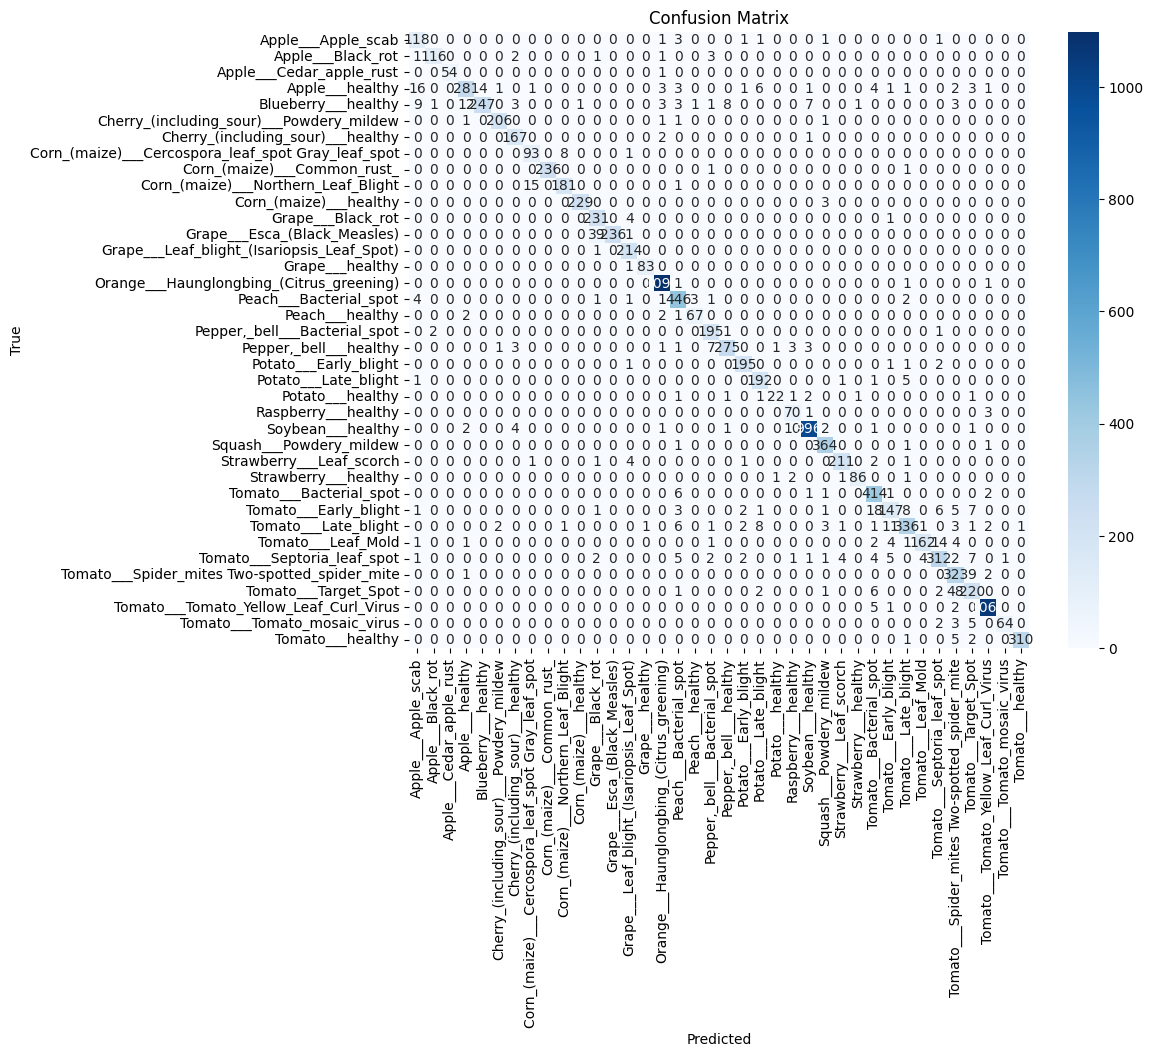

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.78      0.94      0.85       126
                                 Apple___Black_rot       0.97      0.94      0.95       124
                          Apple___Cedar_apple_rust       1.00      0.98      0.99        55
                                   Apple___healthy       0.94      0.85      0.89       329
                               Blueberry___healthy       0.98      0.82      0.90       300
          Cherry_(including_sour)___Powdery_mildew       0.98      0.98      0.98       210
                 Cherry_(including_sour)___healthy       0.93      0.98      0.96       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.85      0.91      0.88       102
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       238
               Corn_(maize)___Northern_Leaf_Blight       0.95      0.92      0.

In [10]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = X_val.classes    
#confusion Matrix
cm = confusion_matrix(y_true,y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel("True")
plt.title('Confusion Matrix')
plt.show()

#Optional : Print Classification report
print(classification_report(y_true,y_pred_classes,target_names=class_names))

In [14]:
val_loss, val_acc = model.evaluate(X_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

340/340 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9393 - loss: 0.2171
Validation Accuracy: 94.57%
